In [1]:
import cv2
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

2024-11-08 18:27:41.981972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 18:27:42.325319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 18:27:42.442377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 18:27:42.472801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 18:27:42.751674: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
DATA_DIR = "fight-detection-surv-dataset"
CLASS_NAMES = ["fight","noFight"]
SEQUENCE_LENGTH = 8
IMG_HEIGHT , IMG_WIDTH = 150,150
BATCHES = 32
CHANNELS = 3
INPUT_SHAPE = (SEQUENCE_LENGTH,IMG_HEIGHT,IMG_WIDTH,CHANNELS)
LABEL_POSITION = (10, 30) #(x,y)
LABEL_FONT = cv2.FONT_HERSHEY_SIMPLEX
LABEL_FONT_SIZE = 0.8
LABEL_COLOR = (0, 0, 255)  # White color in BGR
LABEL_THICKNESS = 2

In [4]:
def frame_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
        success,frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame,(IMG_HEIGHT,IMG_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return np.asarray(frames_list)
    

In [5]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []
    for class_index,class_name in enumerate(CLASS_NAMES):
        print(class_name)
        files_path = os.listdir(os.path.join(DATA_DIR,class_name))
        for file_name in files_path:
            video_file_path = os.path.join(DATA_DIR,class_name,file_name)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)
    features = np.asarray(features)
    lables = np.array(labels)
    return features,labels,video_file_paths

In [6]:
features,labels,video_file_paths = create_dataset()

fight
noFight


In [13]:
features.shape

(300, 8, 150, 150, 3)

In [15]:
encoded_labels = tf.keras.utils.to_categorical(labels)

In [17]:
from sklearn.model_selection import train_test_split
features_train,features_test,lables_train,labels_test = train_test_split(features,encoded_labels,test_size=0.3)

In [19]:
cnn_bi_lstm_model = Sequential([
    InputLayer(shape=INPUT_SHAPE),
    TimeDistributed(Conv2D(filters=32,kernel_size=3,strides=2,activation="relu")),
    TimeDistributed(MaxPool2D(pool_size=(2,2))),
    TimeDistributed(Conv2D(filters=64,kernel_size=3,strides=2,activation="relu")),
    TimeDistributed(MaxPool2D(pool_size=(2,2))),
    TimeDistributed(Flatten()),
    Bidirectional(LSTM(units=8,activation="relu",return_sequences=True)),
    Bidirectional(LSTM(units=16,activation="relu",return_sequences=False)),
    Flatten(),
    Dense(units=512,activation="relu"),
    Dense(units=2, activation="sigmoid")
])
cnn_bi_lstm_model.summary()

2024-11-08 18:28:56.687834: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 8, 74, 74, 32)  │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 8, 37, 37, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 8, 18, 18, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 8, 9, 9, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 8, 5184)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 16)          │       332,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,890 (1.43 MB)

 Trainable params: 373,890 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
cnn_bi_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(),loss = tf.keras.losses.categorical_crossentropy,metrics=["accuracy"])
cnn_bi_lstm_model_history = cnn_bi_lstm_model.fit(x = features_train,y = lables_train,epochs = 30,validation_data = (features_test,labels_test))

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 556ms/step - accuracy: 0.6034 - loss: 0.7021 - val_accuracy: 0.4556 - val_loss: 0.7140
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.5280 - loss: 0.6864 - val_accuracy: 0.5556 - val_loss: 0.6923
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.6231 - loss: 0.6826 - val_accuracy: 0.4778 - val_loss: 0.6945
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.6008 - loss: 0.6670 - val_accuracy: 0.5111 - val_loss: 0.6997
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 0.6513 - loss: 0.6329 - val_accuracy: 0.5222 - val_loss: 1.3992
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.6259 - loss: 0.7502 - val_accuracy: 0.5444 - val_loss: 0.6910
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.6106 - loss: 0.6449 - val_accuracy: 0.5444 - val_loss: 0.6880
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.6295 - loss: 0.6327 - val_accuracy: 0.5333 - val_loss

In [25]:
cnn_bi_lstm_model_train_accuracy = cnn_bi_lstm_model_history.history["accuracy"]
cnn_bi_lstm_model_val_accuracy = cnn_bi_lstm_model_history.history["val_accuracy"]
cnn_bi_lstm_model_train_loss = cnn_bi_lstm_model_history.history["loss"]
cnn_bi_lstm_model_val_loss = cnn_bi_lstm_model_history.history["val_loss"]

In [37]:
import pandas as pd
cnn_bi_lstm_model_history_df = pd.DataFrame(cnn_bi_lstm_model_history.history)
cnn_bi_lstm_model_history_df.to_csv("cnn_bi_lstm_model_history.csv")

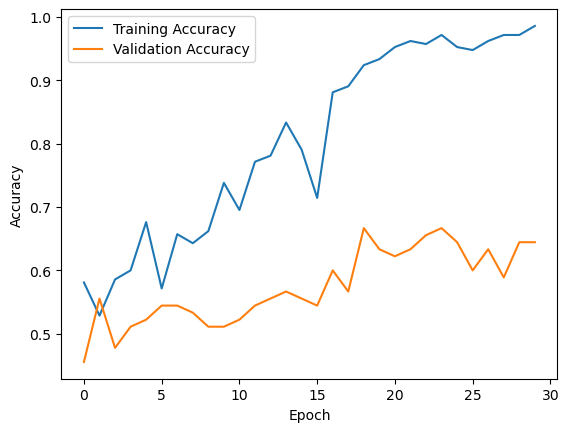

<Figure size 640x480 with 0 Axes>

In [29]:
sns.lineplot(x = cnn_bi_lstm_model_history.epoch,y = cnn_bi_lstm_model_train_accuracy,label = "Training Accuracy")
sns.lineplot(x = cnn_bi_lstm_model_history.epoch,y = cnn_bi_lstm_model_val_accuracy,label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig("cnn_bi_lstm_model_acc.png")

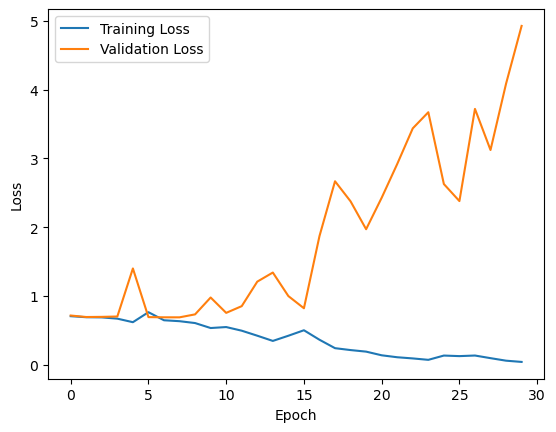

<Figure size 640x480 with 0 Axes>

In [31]:
sns.lineplot(x = cnn_bi_lstm_model_history.epoch,y = cnn_bi_lstm_model_train_loss,label = "Training Loss")
sns.lineplot(x = cnn_bi_lstm_model_history.epoch,y = cnn_bi_lstm_model_val_loss,label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("cnn_bi_lstm_model_loss.png")